In [ ]:
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/brain_tumor_dataset.py --output brain_tumor_dataset.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/classification_models.py --output classification_models.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/trainer.py --output trainer.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   640  100   640    0     0   4637      0 --:--:-- --:--:-- --:--:--  4604
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4155  100  4155    0     0  34057      0 --:--:-- --:--:-- --:--:-- 34057
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4358  100  4358    0     0  24483      0 --:--:-- --:--:-- --:--:-- 24483


## Import modules

In [ ]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images

import matplotlib.pyplot as plt                       # Visualize images and more

from brain_tumor_dataset import BrainTumorDataset     # Dataset
import classification_models as models                # Module for models
from trainer import Trainer, ModelCheckpoint          # Trainer Class

## Preprocessing Dataset | (from .mat to .npy)

Download and unzip dataset

In [ ]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  838M  100  838M    0     0  26.5M      0  0:00:31  0:00:31 --:--:-- 27.9M
Archive:  data.zip
 extracting: ./tmp_dataset/brainTumorDataPublic_1-766.zip  
 extracting: ./tmp_dataset/brainTumorDataPublic_1533-2298.zip  
 extracting: ./tmp_dataset/brainTumorDataPublic_767-1532.zip  
 extracting: ./tmp_dataset/brainTumorDataPublic_2299-3064.zip  
 extracting: ./tmp_dataset/cvind.mat  
 extracting: ./tmp_dataset/README.txt  
Archive:  ./tmp_dataset/brainTumorDataPublic_1533-2298.zip
  inflating: ./tmp_dataset/1533.mat  
  inflating: ./tmp_dataset/1534.mat  
  inflating: ./tmp_dataset/1535.mat  
  inflating: ./tmp_dataset/1536.mat  
  inflating: ./tmp_dataset/1537.mat  
  inflating: ./tmp_dataset/1538.mat  
  inflating: ./tmp_dataset/1539.mat  
  inflating: ./tmp_dataset/1540.mat  
  inflating: ./tmp_dataset/1541.mat  
  inflating: 

Convert .mat to .npy

In [ ]:
data_tmp = {'image':[], 'label':[]}
index = 0
for i in range(3064):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    img = np.array(f.get('cjdata/image'), dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data_tmp['image'].append(name)
      data_tmp['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1

Save labels in a CSV file

In [ ]:
df = pd.DataFrame(data_tmp)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data_tmp

Remove MAT files

In [ ]:
!rm -rf tmp_dataset

## Functions Tools

In [ ]:
def split_dataset(dataset, train_size=0.8):
  n = len(dataset)
  n_train = int(n*train_size)
  n_val = n - n_train
  train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])
  return train_dataset, val_dataset

def plot_train_loss(model_dic, label=None, legend='upper center', model_name=None):
  """
     This method allows you to view the history of the loss function per epoch
  """
  train_loss_history = model_dic['train_loss_history']
  x_values = range(1, len(train_loss_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Training loss')
  else:
    plt.title('Training loss using ' + model_name)

  if label is not None:
    plt.plot(x_values, train_loss_history, '-o', label=label)
    plt.legend(loc=legend)
  else:
    plt.plot(x_values, train_loss_history, '-o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

def plot_accuracy(model_dic, model_name=None):
  """
     This method allows you to view the historical accuracy per epoch
  """  
  train_acc_history = model_dic['train_acc_history']
  val_acc_history = model_dic['val_acc_history']
  x_values = range(1, len(train_acc_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Accuracy')
  else:
    plt.title('Accuracy using ' + model_name )
  plt.plot(x_values, train_acc_history, '-o', label='train')
  plt.plot(x_values, val_acc_history, '-o', label='val')
  plt.ylabel('Accuracy')  
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.show()

def plot_metric_from_array(models_dic, plot_name, legend='lower right', plot_data='both', metric='acc'):
  """
     This method allows to visualize the history of the validation 
     accuracy of several models per epoch
  """
  if metric not in ['acc', 'loss']:
    raise ValueError(f"metric:'{metric}' is not a valid value, use: 'acc', 'loss'")
  name = 'accuracy' if metric == 'acc' else 'loss'

  if plot_data == 'both':
    plt.subplots(figsize =(12, 5)) 
    ### Training subplot
    plt.subplot(1, 2, 1) 
  else:
    plt.figure(figsize=(7, 5))

  if plot_data == 'both' or plot_data == 'train':
    for model_name, model_dic in models_dic.items():
      train_acc_history = model_dic['train_'+metric+'_history']
      x_values = range(1, len(train_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Training '+name)
      else:
        plt.title('Training '+name+' using ' + plot_name )
      plt.plot(x_values, train_acc_history, '-o', label=model_name)
    plt.ylabel(name.capitalize())
    plt.xlabel('Epoch')
    plt.legend(loc=legend)

  if plot_data == 'both':
    ### Validation subplot
    plt.subplot(1, 2, 2)  
  if plot_data == 'both' or plot_data == 'val':  
    for model_name, model_dic in models_dic.items():
      val_acc_history = model_dic['val_'+metric+'_history']
      x_values = range(1, len(val_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Validation '+name)
      else:
        plt.title('Validation '+name+' using ' + plot_name )
      plt.plot(x_values, val_acc_history, '-o', label=model_name)   
    if plot_data == 'val':
      plt.ylabel(name.capitalize()) 
    plt.xlabel('Epoch')
    plt.legend(loc=legend)
  plt.show()

## Config GPU and Seed

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cuda


In [ ]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

## Load Dataset and Create DataLoaders

In [ ]:
# Load Dataset
dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = split_dataset(dataset)
len(train_data), len(test_data)

(2439, 610)

In [ ]:
# Split train_data for training and validation
train_set, val_set = split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [ ]:
# Create Loaders
train_dataloader = data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = data.DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = data.DataLoader(test_data, batch_size=32, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dataloader))
print('Validation data: ', len(val_dataloader))
print('Test data: ', len(test_dataloader))

Number of batches
---------------------
Training data:  58
Validation data:  20
Test data:  20


## View Dataset

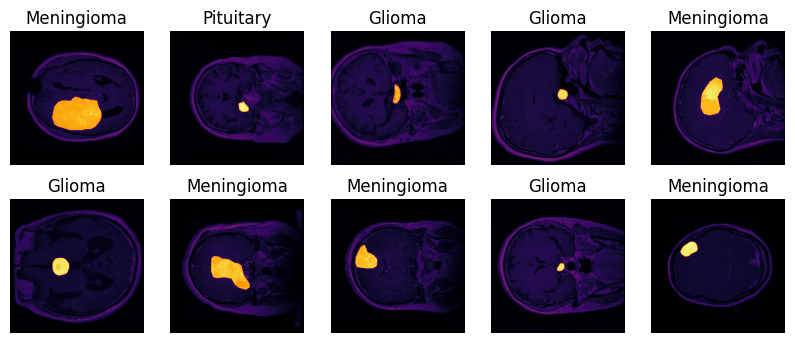

In [ ]:
labels = ['Meningioma', 'Glioma', 'Pituitary']
plt.figure(figsize=(10, 4))
for i in range(10):
  index = random.randint(0, len(train_data)-1)
  image, label = train_data[index]
  image = (image*0.5 + 0.5).numpy()
  
  mask = 0.5*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(labels[label.item()-1]))
  plt.imshow(mask, cmap='inferno')

## 5-Layer Models

In [ ]:
def DownSample(input_, output_, kernel=3, padding=1, pooling=2, batch=True, activation='ReLU'):
  act = None
  if activation == 'ReLU':
    act = nn.ReLU()
  elif activation == 'LeakyReLU':
    act = nn.LeakyReLU(0.02)
  elif activation == 'SELU':
    act = nn.SELU()
  else:
    raise ValueError(f"'{activation}' is not allowed")

  seq = nn.Sequential(nn.Conv2d(input_, output_, kernel_size=kernel, padding=padding))
  if batch:
    seq.append(nn.BatchNorm2d(output_))
  seq.append(act)
  seq.append(nn.MaxPool2d(pooling, stride=pooling))
  return seq

In [ ]:
class FiveLayerSelu(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(                                  #   2  512 512
      DownSample(2, 8, batch=False),                           #   8  256 256
      DownSample(8, 16),                                       #   16 128 128
      DownSample(16, 32),                                      #   32  64  64
      DownSample(32, 64),        #   64  16  16
      DownSample(64, 128, activation='SELU'),       #  128   4   4
      DownSample(128, 512, pooling=4, activation='SELU'), 
      DownSample(512, 512, pooling=4, activation='SELU'),     #  512   1   1
    )
    self.classificator = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 256),
      nn.SELU(),
      nn.Linear(256, 128),
      nn.SELU(),
      nn.Linear(128, 64),
      nn.SELU(),
      nn.Linear(64, 32),
      nn.SELU(),
      nn.Linear(32, 3),
    )

  def forward(self, X):
    return self.classificator(self.net(X))

In [ ]:
class FiveLayerLeakyReLU(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(                                  #   2  512 512
      DownSample(2, 8, batch=False),                           #   8  256 256
      DownSample(8, 16),                                       #   16 128 128
      DownSample(16, 32),                                      #   32  64  64
      DownSample(32, 64),        #   64  16  16
      DownSample(64, 128, activation='LeakyReLU'),       #  128   4   4
      DownSample(128, 512, pooling=4, activation='LeakyReLU'), 
      DownSample(512, 512, pooling=4, activation='LeakyReLU'),     #  512   1   1
    )
    self.classificator = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.02),
      nn.Linear(256, 128),
      nn.LeakyReLU(0.02),
      nn.Linear(128, 64),
      nn.LeakyReLU(0.02),
      nn.Linear(64, 32),
      nn.LeakyReLU(0.02),
      nn.Linear(32, 3),
    )

  def forward(self, X):
    return self.classificator(self.net(X))

In [ ]:
class FiveLayerReLU(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(                                  #   2  512 512
      DownSample(2, 8, batch=False),                           #   8  256 256
      DownSample(8, 16),                                       #   16 128 128
      DownSample(16, 32),                                      #   32  64  64
      DownSample(32, 64),        #   64  16  16
      DownSample(64, 128, activation='ReLU'),       #  128   4   4
      DownSample(128, 512, pooling=4, activation='ReLU'), 
      DownSample(512, 512, pooling=4, activation='ReLU'),     #  512   1   1
    )
    self.classificator = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 3),
    )

  def forward(self, X):
    return self.classificator(self.net(X))

### Training

In [ ]:
model = FiveLayerSelu()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
fivelayerModelWithSELU_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]



Epoch (1/10): train_loss = 1.392376, val_loss= 0.003684, train_acc = 0.442865, val_acc= 0.450820

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:10<00:00,  1.89it/s]



Epoch (2/10): train_loss = 0.969505, val_loss= 0.003435, train_acc = 0.517223, val_acc= 0.532787

val_loss changed (0.003684 -> 0.003435). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.83it/s]



Epoch (3/10): train_loss = 0.832166, val_loss= 0.000808, train_acc = 0.638600, val_acc= 0.740984

val_loss changed (0.003435 -> 0.000808). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.19it/s]



Epoch (4/10): train_loss = 0.459430, val_loss= 0.000586, train_acc = 0.802624, val_acc= 0.739344

val_loss changed (0.000808 -> 0.000586). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.16it/s]



Epoch (5/10): train_loss = 0.498434, val_loss= 0.000057, train_acc = 0.790596, val_acc= 0.875410

val_loss changed (0.000586 -> 0.000057). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.23it/s]



Epoch (6/10): train_loss = 0.352386, val_loss= 0.000365, train_acc = 0.868234, val_acc= 0.840984



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.94it/s]



Epoch (7/10): train_loss = 0.280327, val_loss= 0.000028, train_acc = 0.899945, val_acc= 0.852459

val_loss changed (0.000057 -> 0.000028). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.23it/s]



Epoch (8/10): train_loss = 0.287663, val_loss= 0.000057, train_acc = 0.902679, val_acc= 0.913115



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.15it/s]



Epoch (9/10): train_loss = 0.214910, val_loss= 0.000059, train_acc = 0.922362, val_acc= 0.929508



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.35it/s]


Epoch (10/10): train_loss = 0.186147, val_loss= 0.000229, train_acc = 0.932750, val_acc= 0.880328



In [ ]:
model = FiveLayerLeakyReLU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
FiveLayerLeakyReLU_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.96it/s]



Epoch (1/10): train_loss = 0.937255, val_loss= 0.001804, train_acc = 0.525970, val_acc= 0.644262

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.26it/s]



Epoch (2/10): train_loss = 0.724052, val_loss= 0.002624, train_acc = 0.661564, val_acc= 0.709836



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.81it/s]



Epoch (3/10): train_loss = 0.575142, val_loss= 0.000958, train_acc = 0.728814, val_acc= 0.759016

val_loss changed (0.001804 -> 0.000958). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.93it/s]



Epoch (4/10): train_loss = 0.458714, val_loss= 0.000184, train_acc = 0.807545, val_acc= 0.852459

val_loss changed (0.000958 -> 0.000184). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.83it/s]



Epoch (5/10): train_loss = 0.391562, val_loss= 0.000092, train_acc = 0.848551, val_acc= 0.814754

val_loss changed (0.000184 -> 0.000092). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.22it/s]



Epoch (6/10): train_loss = 0.329029, val_loss= 0.000012, train_acc = 0.882996, val_acc= 0.918033

val_loss changed (0.000092 -> 0.000012). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.64it/s]



Epoch (7/10): train_loss = 0.550474, val_loss= 0.000095, train_acc = 0.781301, val_acc= 0.834426



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.13it/s]



Epoch (8/10): train_loss = 0.333741, val_loss= 0.000052, train_acc = 0.869328, val_acc= 0.906557



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.17it/s]



Epoch (9/10): train_loss = 0.270572, val_loss= 0.000406, train_acc = 0.911974, val_acc= 0.829508



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.10it/s]


Epoch (10/10): train_loss = 0.253156, val_loss= 0.000114, train_acc = 0.904319, val_acc= 0.901639



In [ ]:
model = FiveLayerReLU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
FiveLayerReLU_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:04<00:00,  4.45it/s]



Epoch (1/10): train_loss = 0.882045, val_loss= 0.001956, train_acc = 0.580098, val_acc= 0.655738

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.12it/s]



Epoch (2/10): train_loss = 0.688350, val_loss= 0.001022, train_acc = 0.690541, val_acc= 0.662295

val_loss changed (0.001956 -> 0.001022). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.21it/s]



Epoch (3/10): train_loss = 0.581849, val_loss= 0.000064, train_acc = 0.755604, val_acc= 0.801639

val_loss changed (0.001022 -> 0.000064). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.78it/s]



Epoch (4/10): train_loss = 0.495142, val_loss= 0.000011, train_acc = 0.832149, val_acc= 0.906557

val_loss changed (0.000064 -> 0.000011). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:07<00:00,  2.57it/s]



Epoch (5/10): train_loss = 0.313692, val_loss= 0.000025, train_acc = 0.898305, val_acc= 0.916393



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.28it/s]



Epoch (6/10): train_loss = 0.450329, val_loss= 0.000142, train_acc = 0.849098, val_acc= 0.860656



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]



Epoch (7/10): train_loss = 0.333619, val_loss= 0.000034, train_acc = 0.887917, val_acc= 0.929508



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.23it/s]



Epoch (8/10): train_loss = 0.292504, val_loss= 0.000226, train_acc = 0.902679, val_acc= 0.895082



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.82it/s]



Epoch (9/10): train_loss = 0.240112, val_loss= 0.000000, train_acc = 0.917988, val_acc= 0.927869

val_loss changed (0.000011 -> 0.000000). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:04<00:00,  4.32it/s]


Epoch (10/10): train_loss = 0.220448, val_loss= 0.000151, train_acc = 0.925642, val_acc= 0.924590



<ipython-input-7-10f1849b0732>:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


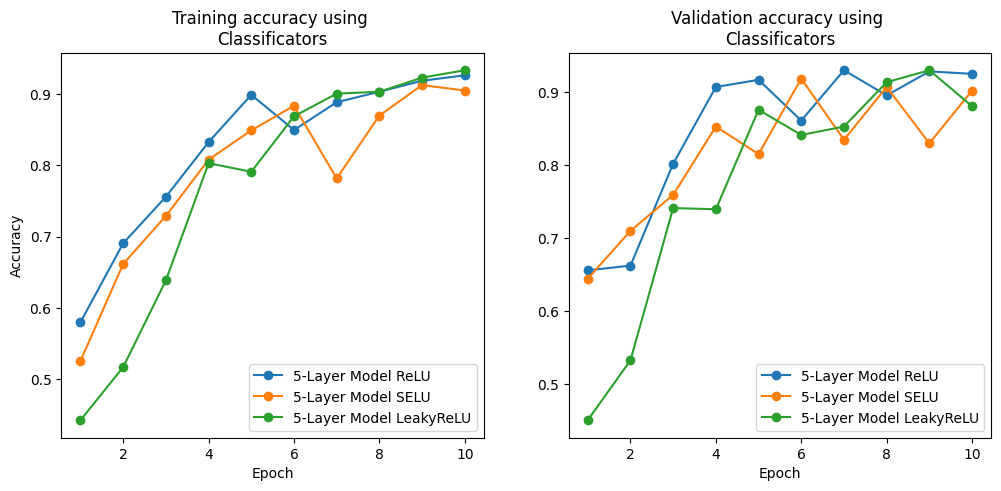

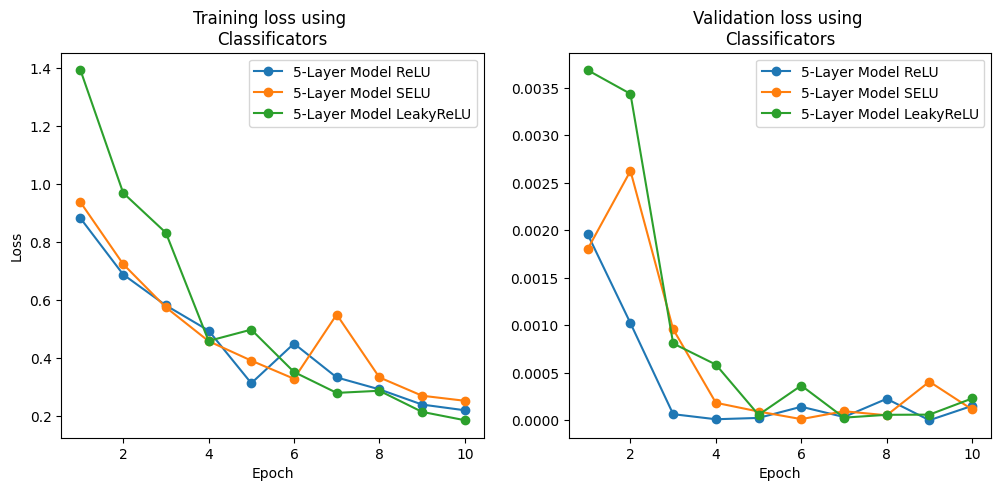

In [ ]:
info = {
    '5-Layer Model ReLU': FiveLayerReLU_dic,
    '5-Layer Model SELU': FiveLayerLeakyReLU_dic,
    '5-Layer Model LeakyReLU': fivelayerModelWithSELU_dic,
}

plot_metric_from_array(info, '\nClassificators')
plot_metric_from_array(info, '\nClassificators', metric='loss', legend='upper right')